In [202]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore")
import os
import seaborn as sns

from utils import *
from tqdm.auto import tqdm
from generate_parameter_sample import PARAMETER_RANGES
from scipy.stats import gaussian_kde, ks_2samp
import numpy as np
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay, PartialDependenceDisplay

from experiment import unpack_and_dequantize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [203]:
# define results directories
cpt_dir = "../cpt/"
pt_dir = "../pt/"
eut_dir = "../eut"
# significant amplitude threshold
significant_amplitude_thresold = 20

# Heatmap for Dominant Amplitudes

### CPT

In [204]:
directory = "cpt"
with open("../"+directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
    freqs = pickle.load(f)
data = []
for idx,f in tqdm(enumerate(os.listdir("../"+directory))):
    with open(os.path.join("../"+directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["gamma"], P["lambda"], P["rate"], P["A"], P["shock_size"], freqs[idx]["amplitudes"]))
    data.append(elem)

0it [00:00, ?it/s]

KeyboardInterrupt: 

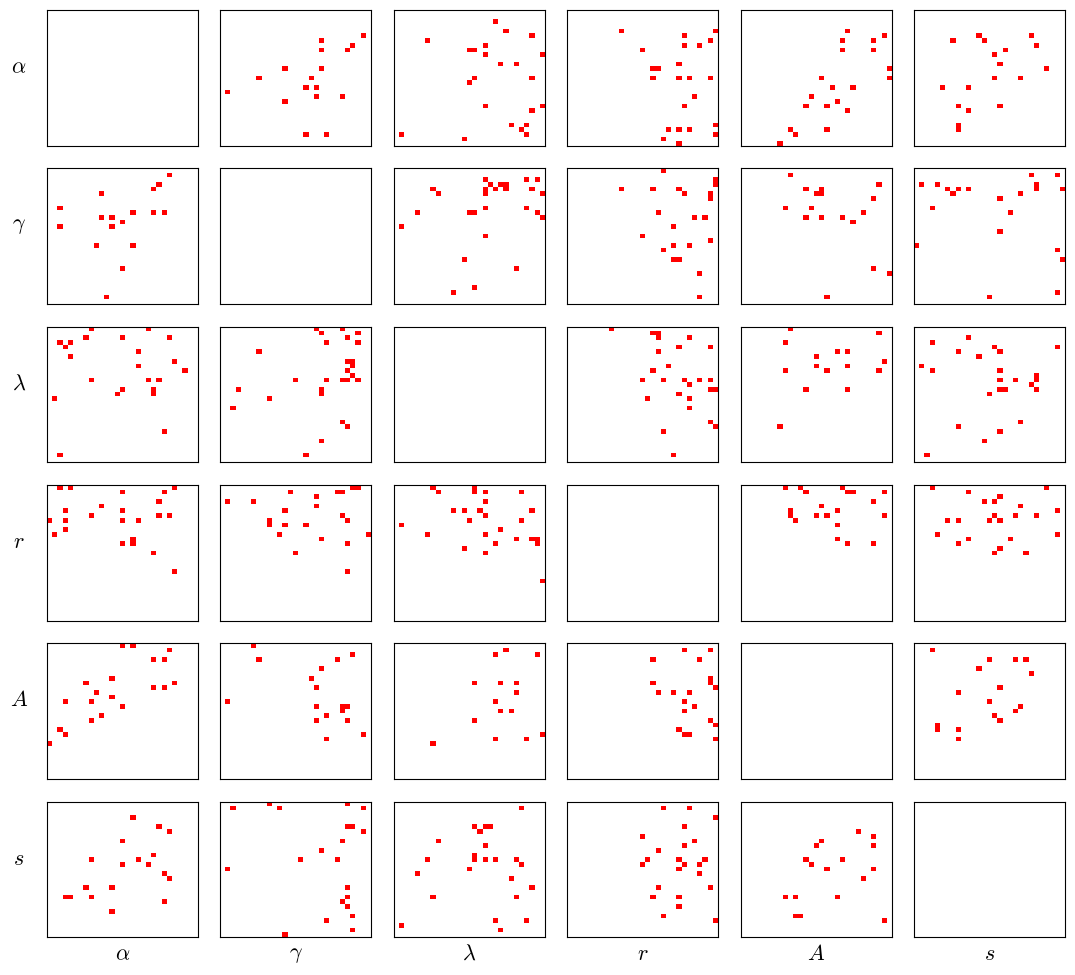

In [ ]:
param_names = [r"$\alpha$", r"$\gamma$", r"$\lambda$", r"$r$", r"$A$", r"$s$"]
bounds = list(PARAMETER_RANGES.values())
freq_lists = [d[-1] for d in data]

num_bins = 30

fig, axs = plt.subplots(len(param_names), len(param_names), figsize=(11,10))

for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], num_bins)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], num_bins)
        heatmap = np.zeros((num_bins-1, num_bins-1))
        
        # Iterate over bins
        for a in range(num_bins-1):
            for b in range(num_bins-1):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    amplitudes = [freq_lists[k] for k in idxs]
                    if amplitudes:
                        combined = np.concatenate(amplitudes) 
                        combined[np.isnan(combined)] = 0
                        heatmap[a, b] = combined.mean()
                    else:
                        heatmap[a, b] = 0
                else:
                    heatmap[a, b] = 0

        # Threshold mask: 1 if >= 20, else 0
        mask = (heatmap >= 20).astype(int)
        # Two-color colormap: white (0) and red (1)
        from matplotlib.colors import ListedColormap
        cmap = ListedColormap(["white", "red"])
        im = axs[i][j].imshow(mask, origin="lower", aspect="auto", cmap=cmap, vmin=0, vmax=1)
            
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])

        last_im = im

fig.tight_layout()
# fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9)
plt.show()

### PT

In [ ]:
directory = "pt"
with open("../"+directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
    freqs = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir("../"+directory))):
    with open(os.path.join("../"+directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["rate"], P["A"], P["shock_size"], freqs[idx]["amplitudes"]))
    data.append(elem)

0it [00:00, ?it/s]

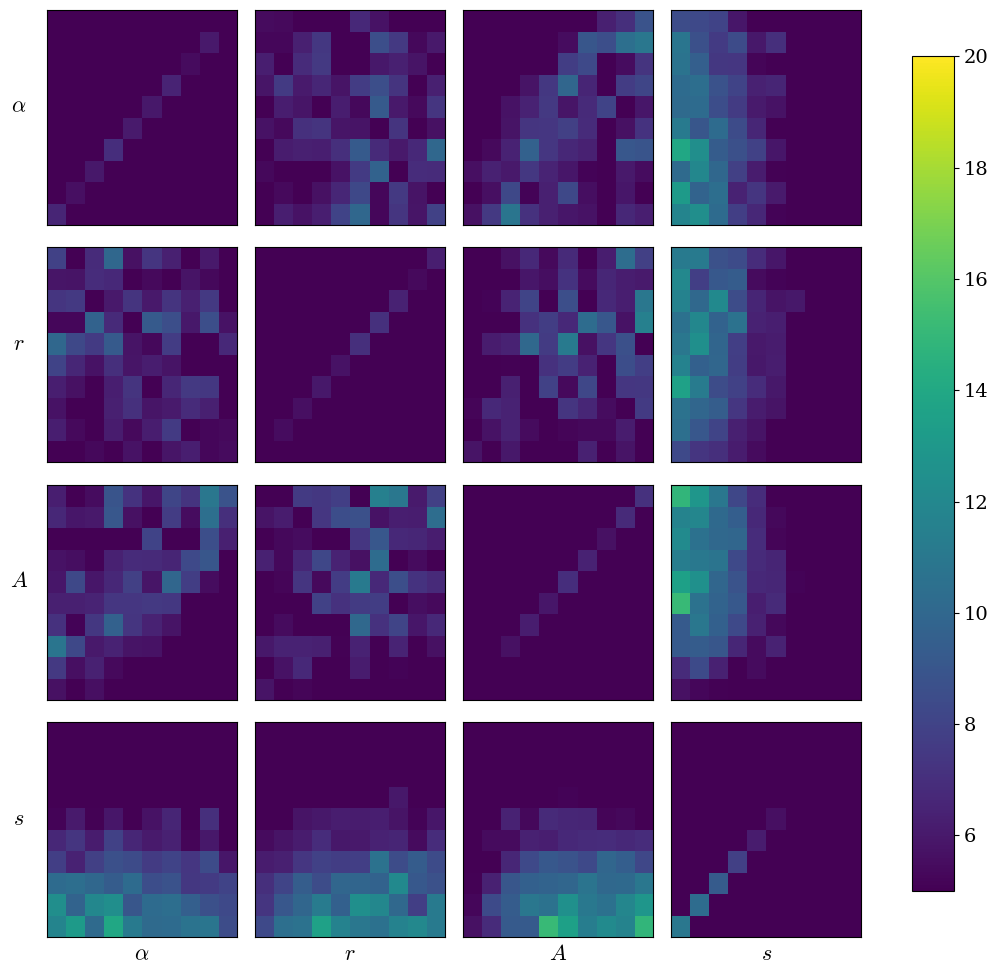

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(11,10))

param_names = [r"$\alpha$", r"$r$", r"$A$", r"$s$"]
bounds = list([PARAMETER_RANGES[k] for k in ["alpha", "rate", "A", "shock_size"]])
freq_lists = [d[-1] for d in data]

map_vals = []
for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))

        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    amplitudes = [freq_lists[k] for k in idxs]
                    if amplitudes:
                        combined = np.concatenate(amplitudes) 
                        combined[np.isnan(combined)] = 0
                        heatmap[a, b] = combined.mean()
                    else:
                        heatmap[a,b] = 0
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=5, vmax=20)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])
        last_im = im

        map_vals.append(heatmap.flatten())

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

# KDE of Dominant Amplitudes

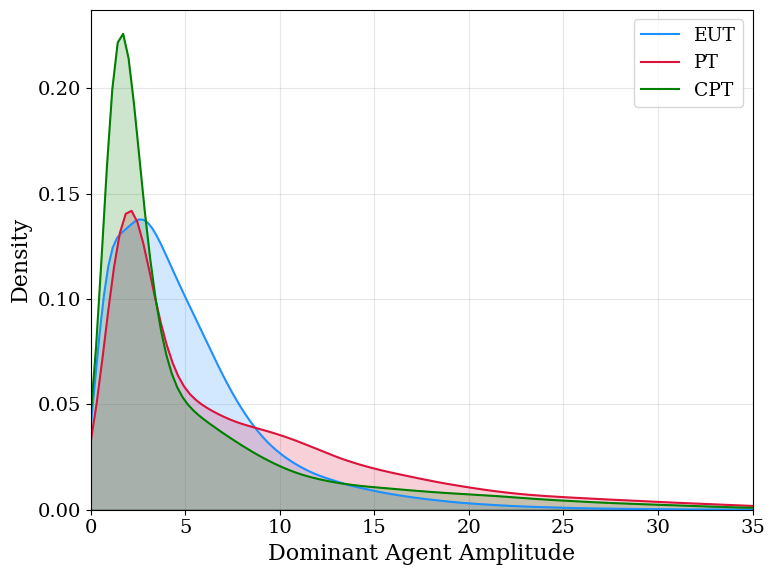

In [ ]:
labels = ["EUT", "PT", "CPT"]
colors = ["dodgerblue", "crimson", "green"]

for i, model in enumerate(["../eut", "../pt", "../cpt"]):
    with open(model + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
        amplitudes = pickle.load(f)

    sims = [s["amplitudes"] for s in amplitudes]
    sims = np.concatenate(sims)
    sims = sims[~np.isnan(sims)]

    # compute KDE
    kde = gaussian_kde(sims, bw_method=0.1)

    # grid for x-values
    x_vals = np.linspace(min(sims), max(sims), 200)
    y_vals = kde(x_vals)

    y_vals /= np.trapz(y_vals, x_vals)
    plt.plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=1.5)
    plt.fill_between(x_vals, y_vals, color=colors[i], alpha=0.2)

plt.xlabel("Dominant Agent Amplitude")
plt.ylabel("Density")
plt.legend()

max_x_tick = 35
plt.xlim(0, 35)
plt.xticks(np.linspace(0, 35, 8))

plt.ylim(0,)
plt.grid()
plt.tight_layout()
plt.savefig("../figures/agent_amplitude_kde.pdf", bbox_inches="tight")
plt.show()

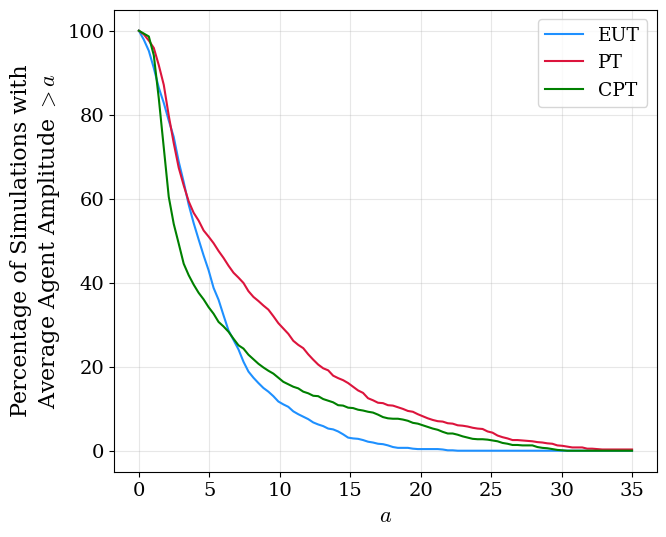

In [ ]:
plt.figure(figsize=(7,6))

cutoffs = np.linspace(0, 35, 100)
labels = ["EUT", "PT", "CPT"]
colors = ["dodgerblue", "crimson", "green"]
for i, model in enumerate(["eut", "pt", "cpt"]):
    with open("../"+model + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
        amplitudes = pickle.load(f)
    count = []
    sims = [s["amplitudes"] for s in amplitudes]
    sims = np.concatenate(sims)
    sims = sims[~np.isnan(sims)]
    for mean_dominant_amplitude in cutoffs:
        subset = [x for x in amplitudes if np.mean(x["amplitudes"]) > mean_dominant_amplitude]
        count.append(100 * len(subset)/1024)
    plt.plot(cutoffs, count, label=labels[i], color=colors[i])

plt.legend()
plt.grid()
plt.ylabel("Percentage of Simulations with" + "\n"+ r"Average Agent Amplitude $> a$")
plt.xlabel(r"$a$")
plt.savefig("../figures/percent_simulations_amplitude.pdf", bbox_inches="tight")
plt.show()

# Radar Plots for Param Values

In [ ]:
def load_data(directory):
    with open(f"../{directory}_dominant_frequencies_amplitudes.pickle", "rb") as f:
        freqs = pickle.load(f)
    y = np.array([np.mean(f["amplitudes"])for f in freqs])

    parameters = []
    for f_name in tqdm(os.listdir(f"../{directory}")):
        if f_name.endswith('.pickle'):
            with open(os.path.join(f"../{directory}", f_name), "rb") as f:
                P = pickle.load(f)["params"]
            # Different parameter sets for CPT vs PT
            if directory == "cpt":
                elem = (P["alpha"], P["gamma"], P["lambda"], P["rate"], P["A"], P["shock_size"])
            elif directory == "pt":
                elem = (P["alpha"], 1, P["lambda"], P["rate"], P["A"], P["shock_size"])
            else:
                elem = (P["alpha"], P["rate"], P["A"], P["shock_size"])
            parameters.append(elem)
    return np.array(parameters), y

# Load data
cpt_P, cpt_y = load_data("cpt")
pt_P, pt_y = load_data("pt")

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

In [ ]:
def prepare_radar_data(params, y, threshold):
    """Compute normalized average values and radar angles for plotting."""
    baseline = params[y<threshold]
    avg_baseline = np.mean(baseline, axis=0)
    min_vals_baseline = np.min(baseline, axis=0)
    max_vals_baseline = np.max(baseline, axis=0)
    normalized_avg_baseline = (avg_baseline - min_vals_baseline) / (max_vals_baseline - min_vals_baseline)

    significant = params[y>=threshold]
    print(len(significant)/1024)
    avg_significant = np.mean(significant, axis=0)
    min_vals_significant = np.min(baseline, axis=0)
    max_vals_significant = np.max(baseline, axis=0)
    normalized_avg_significant = (avg_significant - min_vals_significant) / (max_vals_significant - min_vals_significant)

    # Compute angles for radar plot
    num_vars = params.shape[1]
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Close the radar plot
    normalized_avg_baseline = np.concatenate((normalized_avg_baseline, [normalized_avg_baseline[0]]))
    normalized_avg_significant = np.concatenate((normalized_avg_significant, [normalized_avg_significant[0]]))
    angles += angles[:1]

    return normalized_avg_baseline, normalized_avg_significant, angles

# Prepare radar data
cpt_baseline, cpt_significant, cpt_angles = prepare_radar_data(cpt_P, cpt_y, threshold=20)
pt_baseline, pt_significant, pt_angles = prepare_radar_data(pt_P, pt_y, threshold=20)
pt_significant[np.isnan(pt_significant)] = 1

0.0625
0.083984375


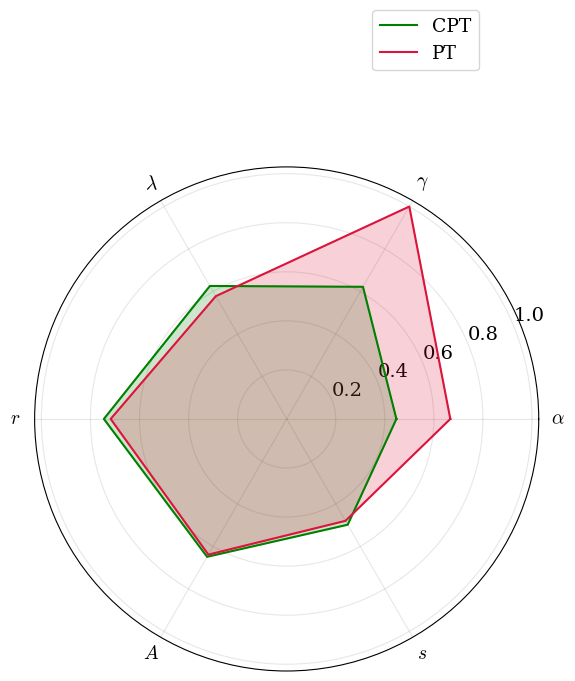

In [ ]:
def plot_radar_chart(ax, angles, data_cpt, data_pt, labels, legend=True):
    """Helper function to plot a single radar chart."""
    ax.plot(angles, data_cpt, color="green", linewidth=1.5, linestyle='solid', label='CPT')
    ax.fill(angles, data_cpt, color="green", alpha=0.2)
    ax.plot(angles, data_pt, color="crimson", linewidth=1.5, linestyle='solid', label='PT')
    ax.fill(angles, data_pt, color="crimson", alpha=0.2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    if legend:
        ax.legend(bbox_to_anchor=(0.9, 1.33))

fig, ax = plt.subplots(1, 1, figsize=(6, 8), subplot_kw=dict(polar=True))
cpt_labels = [r"$\alpha$", r"$\gamma$", r"$\lambda$", r"$r$", r"$A$", r"$s$"]
plot_radar_chart(ax, cpt_angles, cpt_significant, pt_significant, cpt_labels, legend=True)
plt.tight_layout()
plt.savefig("../figures/amplitude_radars.pdf", bbox_inches="tight")
plt.show()

# Large Mean Amplitude Simulations

In [ ]:
params = {k:[] for k in PARAMETER_RANGES}
for f_name in tqdm(os.listdir(f"../cpt")):
    with open(os.path.join(f"../cpt", f_name), "rb") as f:
        P = pickle.load(f)["params"]
    for k in PARAMETER_RANGES:
        params[k].append(P[k])

  0%|          | 0/1024 [00:00<?, ?it/s]

In [ ]:
threshold = 20
with open("../cpt_dominant_frequencies_amplitudes.pickle", "rb") as f:
    data = pickle.load(f)
sims = [int(np.mean(f["amplitudes"]) >= threshold) for f in data]

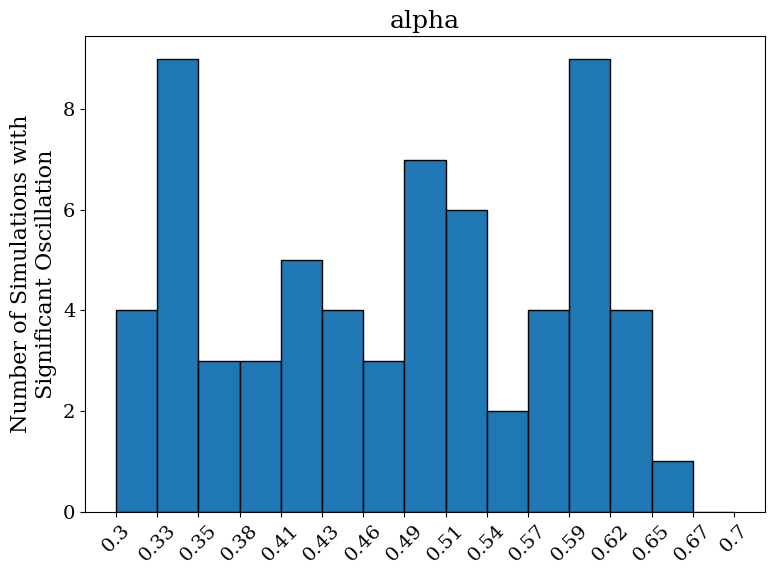

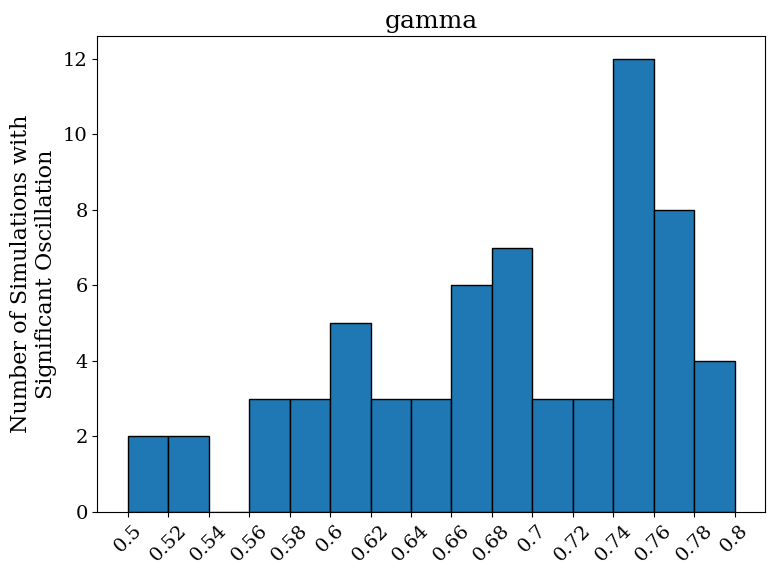

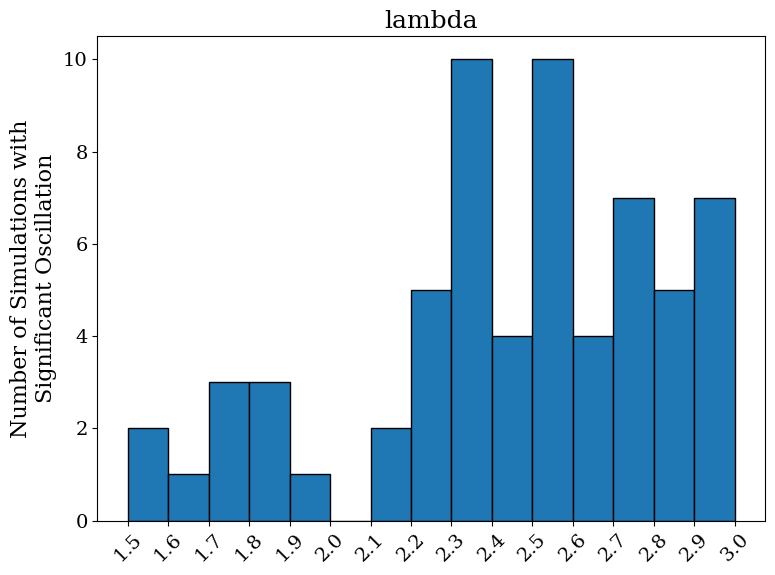

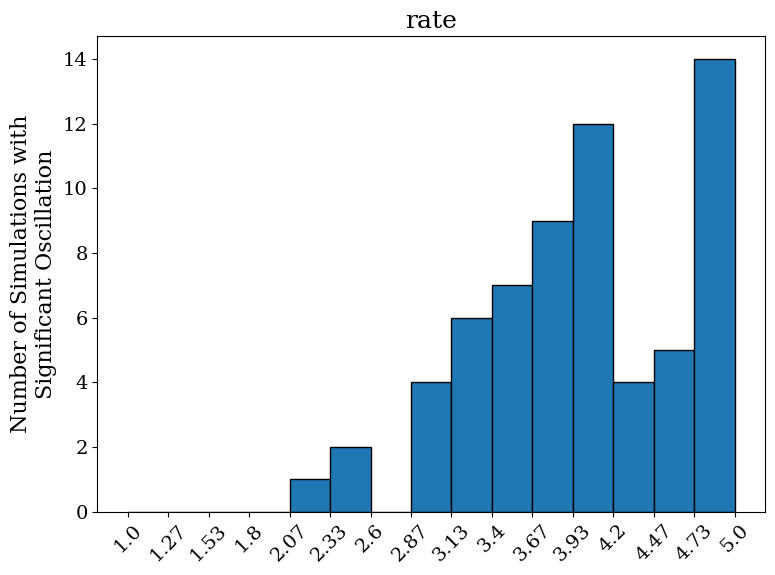

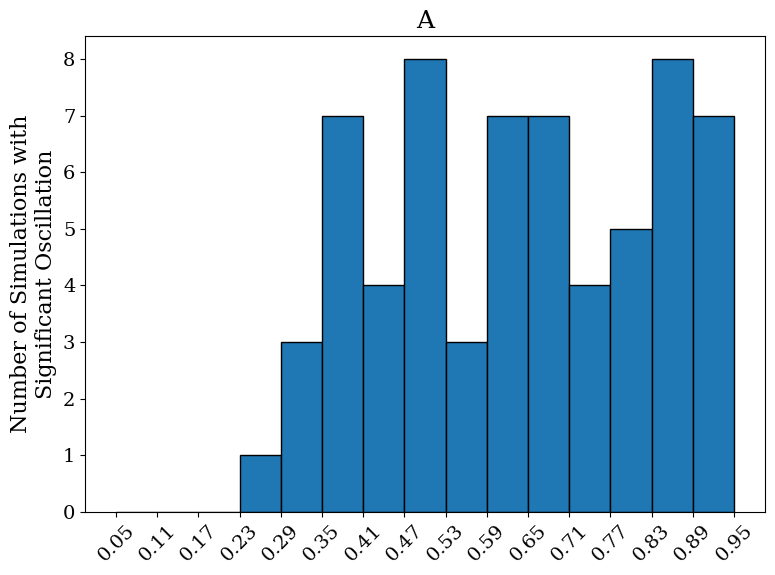

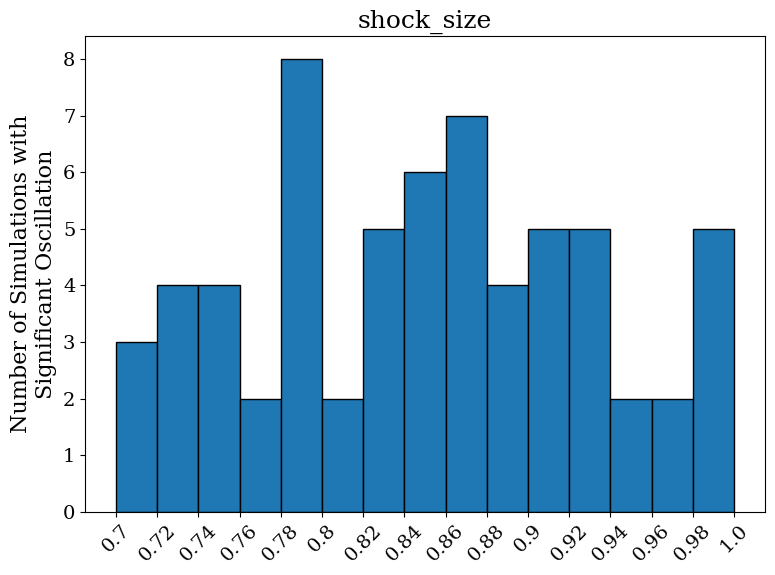

In [ ]:
N = 16
for p, interval in PARAMETER_RANGES.items():
    edges = np.linspace(interval[0], interval[1], N)
    centers = 0.5 * (edges[:-1] + edges[1:])
    high_amplitude_sims = np.zeros(N-1)
    for k in range(1, N):
        for j, val in enumerate(params[p]):
            if edges[k-1] < val <= edges[k] and sims[j]:
                high_amplitude_sims[k-1] += 1

    plt.bar(
        centers,
        high_amplitude_sims,
        width=(edges[1] - edges[0]),
        align="center",
        edgecolor="k"
    )
    plt.xticks(edges, np.round(edges, 2), rotation=45)
    plt.title(p)
    plt.ylabel("Number of Simulations with\nSignificant Oscillation")
    plt.tight_layout()
    plt.show()  

# Analyzing Parameter Values vs. Amplitude

In [294]:
with open("../cpt_dominant_frequencies_amplitudes.pickle", "rb") as f:
    cpt_data = pickle.load(f)
with open("../pt_dominant_frequencies_amplitudes.pickle", "rb") as f:
    pt_data = pickle.load(f)

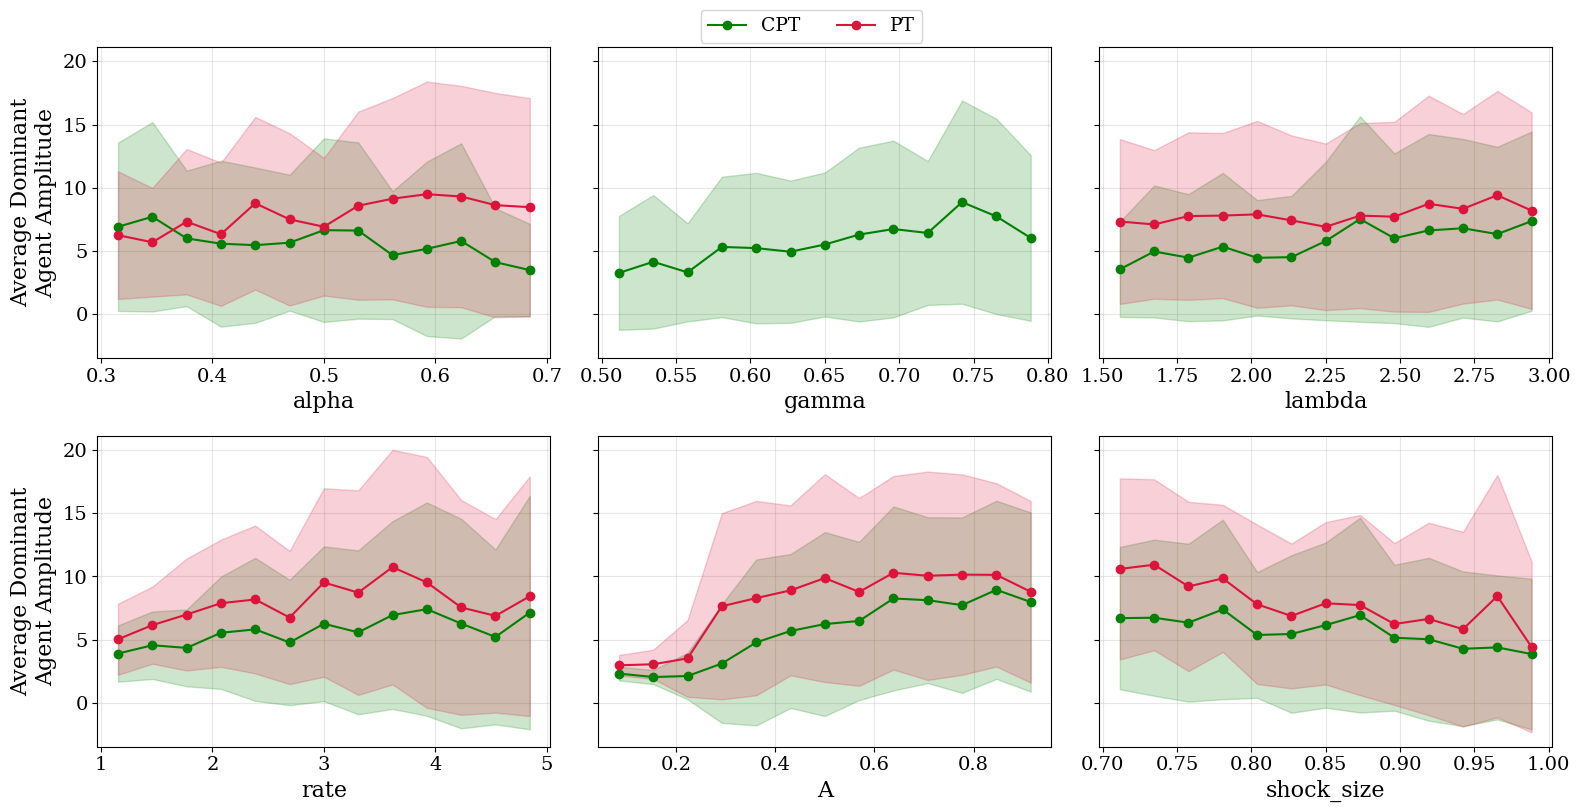

In [ ]:
N = 14

fig, axs = plt.subplots(2,3,figsize=(16, 8), sharey=True)

# --- CPT (green) ---
for idx in range(6):
    parameter = list(PARAMETER_RANGES.keys())[idx]
    row, col = int(idx/3), idx % 3

    edges = np.linspace(PARAMETER_RANGES[parameter][0], PARAMETER_RANGES[parameter][1], N)
    centers = 0.5 * (edges[:-1] + edges[1:])
    sims = [np.mean(f["amplitudes"]) for f in cpt_data]

    means = np.zeros(N-1)
    stds = np.zeros(N-1)

    # collect values by bin
    for k in range(1, N):
        vals_in_bin = [sims[j] for j, val in enumerate([p[idx] for p in cpt_P])
                       if edges[k-1] < val <= edges[k]]
        if len(vals_in_bin) > 0:
            means[k-1] = np.mean(vals_in_bin)
            stds[k-1] = np.std(vals_in_bin)
        else:
            means[k-1] = np.nan
            stds[k-1] = 0

    axs[row][col].plot(centers, means, color="green", marker="o",
                       label="CPT" if idx == 0 else None)

    axs[row][col].fill_between(centers, means - stds, means + stds,
                               color="green", alpha=0.2)


# --- PT (crimson) ---
for idx in range(6):
    parameter = list(PARAMETER_RANGES.keys())[idx]
    row, col = int(idx/3), idx % 3

    edges = np.linspace(PARAMETER_RANGES[parameter][0], PARAMETER_RANGES[parameter][1], N)
    centers = 0.5 * (edges[:-1] + edges[1:])
    sims = [np.mean(f["amplitudes"]) for f in pt_data]

    means = np.zeros(N-1)
    stds = np.zeros(N-1)

    for k in range(1, N):
        vals_in_bin = [sims[j] for j, val in enumerate([p[idx] for p in pt_P])
                       if edges[k-1] < val <= edges[k]]
        if len(vals_in_bin) > 0:
            means[k-1] = np.mean(vals_in_bin)
            stds[k-1] = np.std(vals_in_bin)
        else:
            means[k-1] = np.nan
            stds[k-1] = 0

    axs[row][col].plot(centers, means, color="crimson", marker="o", label="PT" if idx == 0 else None)
    axs[row][col].fill_between(centers, means - stds, means + stds, color="crimson", alpha=0.2)
    axs[row][col].set_xlabel(parameter)
    axs[row][col].grid()


axs[0][0].set_ylabel("Average Dominant\nAgent Amplitude")
axs[1][0].set_ylabel("Average Dominant\nAgent Amplitude")

fig.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.515, 1.03))
fig.tight_layout()
plt.show()


In [224]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Parameter names
param_names = [r"$\alpha$", r"$\gamma$", r"$\lambda$", r"$r$", r"$A$", r"$s$"]

def analyze_complete_dynamics(P, y, model_name="CPT"):
    print(f"--- Analyzing {model_name} ---")
    
    # 1. Setup Data
    df = pd.DataFrame(P, columns=param_names)
    df = df.loc[:, df.std() > 0] # Remove constant columns
    active_params = df.columns.tolist()
    
    # 2. Identify Top 2 Drivers (using RF for robust importance)
    rf = RandomForestRegressor(n_estimators=50, random_state=42).fit(df, y)
    importances = pd.Series(rf.feature_importances_, index=active_params).sort_values(ascending=False)
    top_2 = importances.index[:2].tolist()
    x_name, y_name = top_2[0], top_2[1]
    
    print(f"Top Drivers: {x_name} and {y_name}")
    
    # =========================================================
    # FIG 1: THE DECISION TREE (The "Rules")
    # =========================================================
    dt = DecisionTreeRegressor(max_depth=2, random_state=42)
    dt.fit(df, y)
    
    plt.figure(figsize=(10, 5), dpi=100)
    plot_tree(dt, 
              feature_names=active_params, 
              filled=True, 
              rounded=True, 
              precision=2, 
              fontsize=10)
    plt.title(f"{model_name}: Decision Tree", fontsize=16)
    plt.tight_layout()
    plt.show()

    # =========================================================
    # FIG 2: THE REAL DATA HEATMAPS (The "Geography")
    # =========================================================
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # --- SUBPLOT A: HEXBIN (Raw Data) ---
    hb = axes[0].hexbin(df[x_name], df[y_name], C=y, 
                        gridsize=13, 
                        cmap='magma', 
                        reduce_C_function=np.mean,
                        mincnt=1) # Don't plot empty bins
    
    cb1 = fig.colorbar(hb, ax=axes[0])
    cb1.set_label("Avg Amplitude (Raw)")
    axes[0].set_title(f"Raw Data Verification (Hexbin)\n(Empty areas = No samples)", fontsize=14)
    axes[0].set_xlabel(x_name, fontsize=12)
    axes[0].set_ylabel(y_name, fontsize=12)

    # --- SUBPLOT B: k-NN SMOOTHING (Safe Interpolation) ---
    # Prepare k-NN
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[[x_name, y_name]])
    knn = KNeighborsRegressor(n_neighbors=25, weights='distance')
    knn.fit(X_scaled, y)
    
    # Create Grid
    res = 100
    x_grid = np.linspace(df[x_name].min(), df[x_name].max(), res)
    y_grid = np.linspace(df[y_name].min(), df[y_name].max(), res)
    xx, yy = np.meshgrid(x_grid, y_grid)
    
    # Predict
    grid_flat = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = scaler.transform(grid_flat)
    Z = knn.predict(grid_scaled).reshape(xx.shape)
    
    # Plot
    contour = axes[1].contourf(xx, yy, Z, levels=50, cmap="magma")
    cb2 = fig.colorbar(contour, ax=axes[1])
    cb2.set_label("Avg Amplitude (Smoothed)")
    
    # Overlay tiny dots to show sample locations
    axes[1].scatter(df[x_name], df[y_name], c='white', s=2, alpha=0.15)
    
    axes[1].set_title(f"Robust Smoothing (k-NN, k=25)\n(Interpolated trend)", fontsize=14)
    axes[1].set_xlabel(x_name, fontsize=12)
    axes[1].set_ylabel(y_name, fontsize=12)

    plt.tight_layout()
    plt.show()

--- Analyzing PT ---
Top Drivers: $A$ and $\alpha$


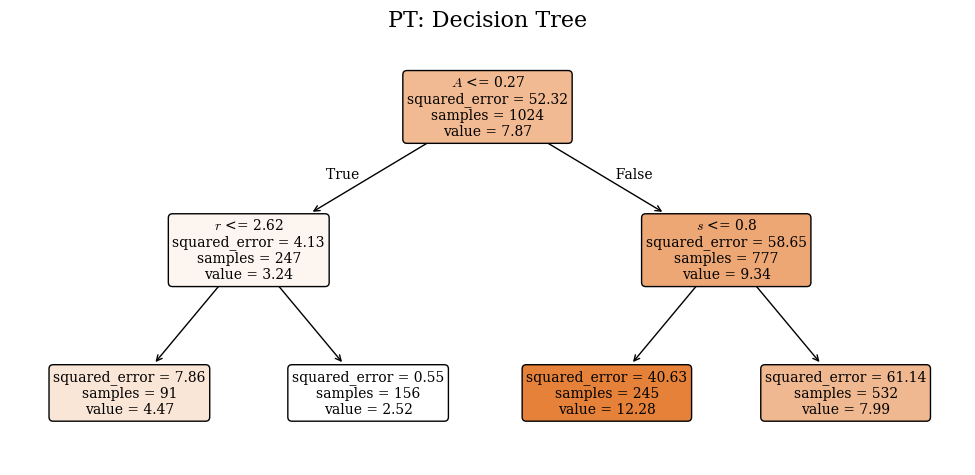

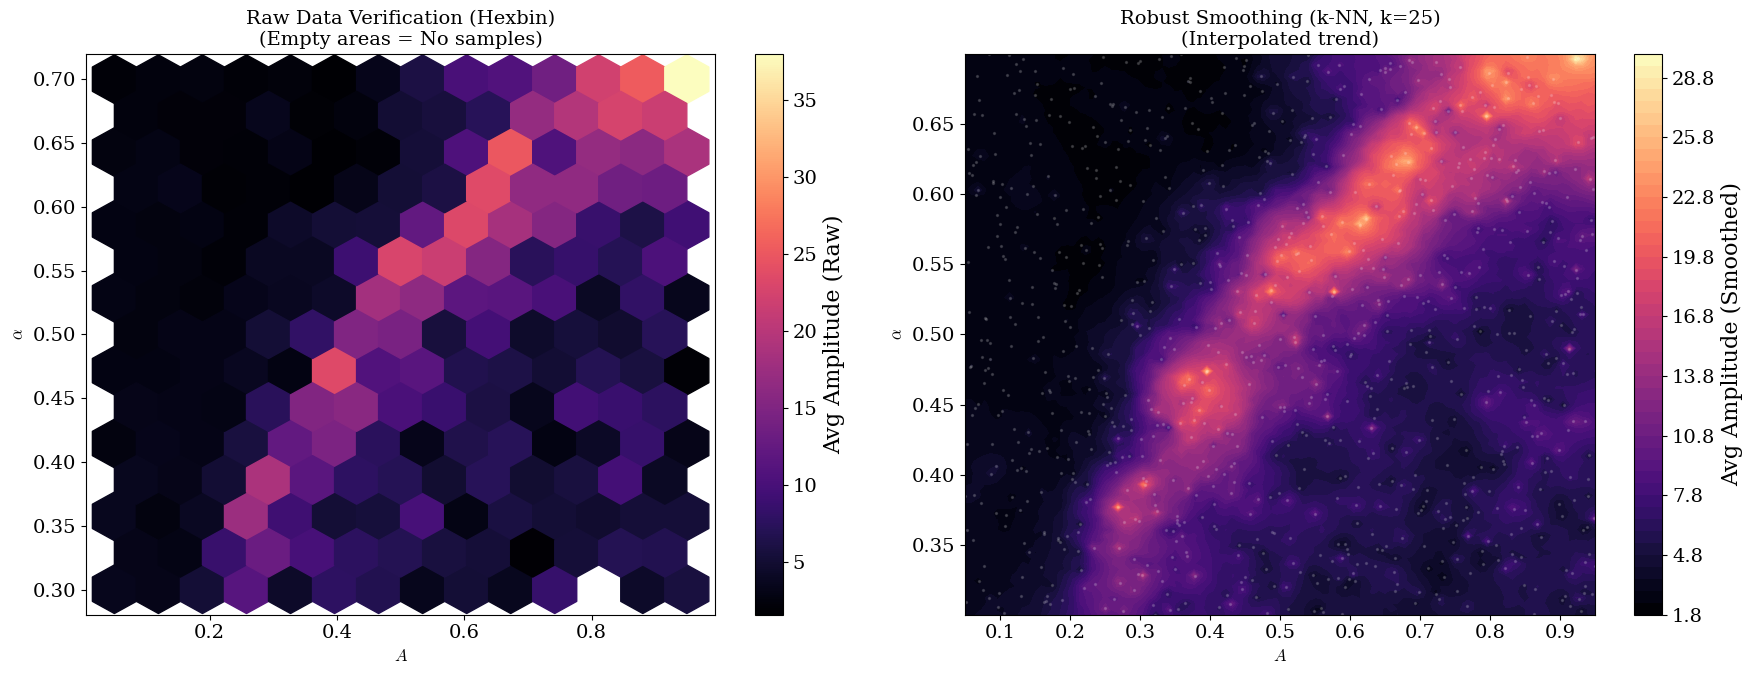

In [225]:
analyze_complete_dynamics(pt_P, pt_y, "PT")

--- Analyzing CPT ---
Top Drivers: $A$ and $\alpha$


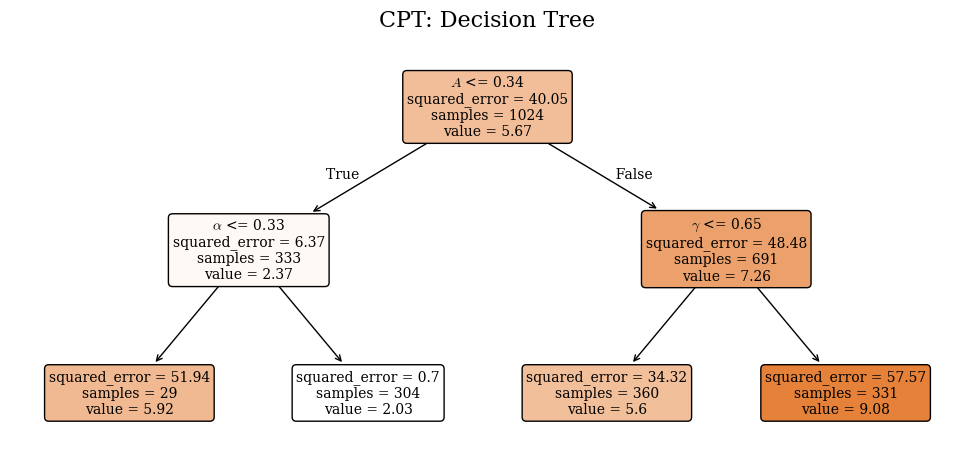

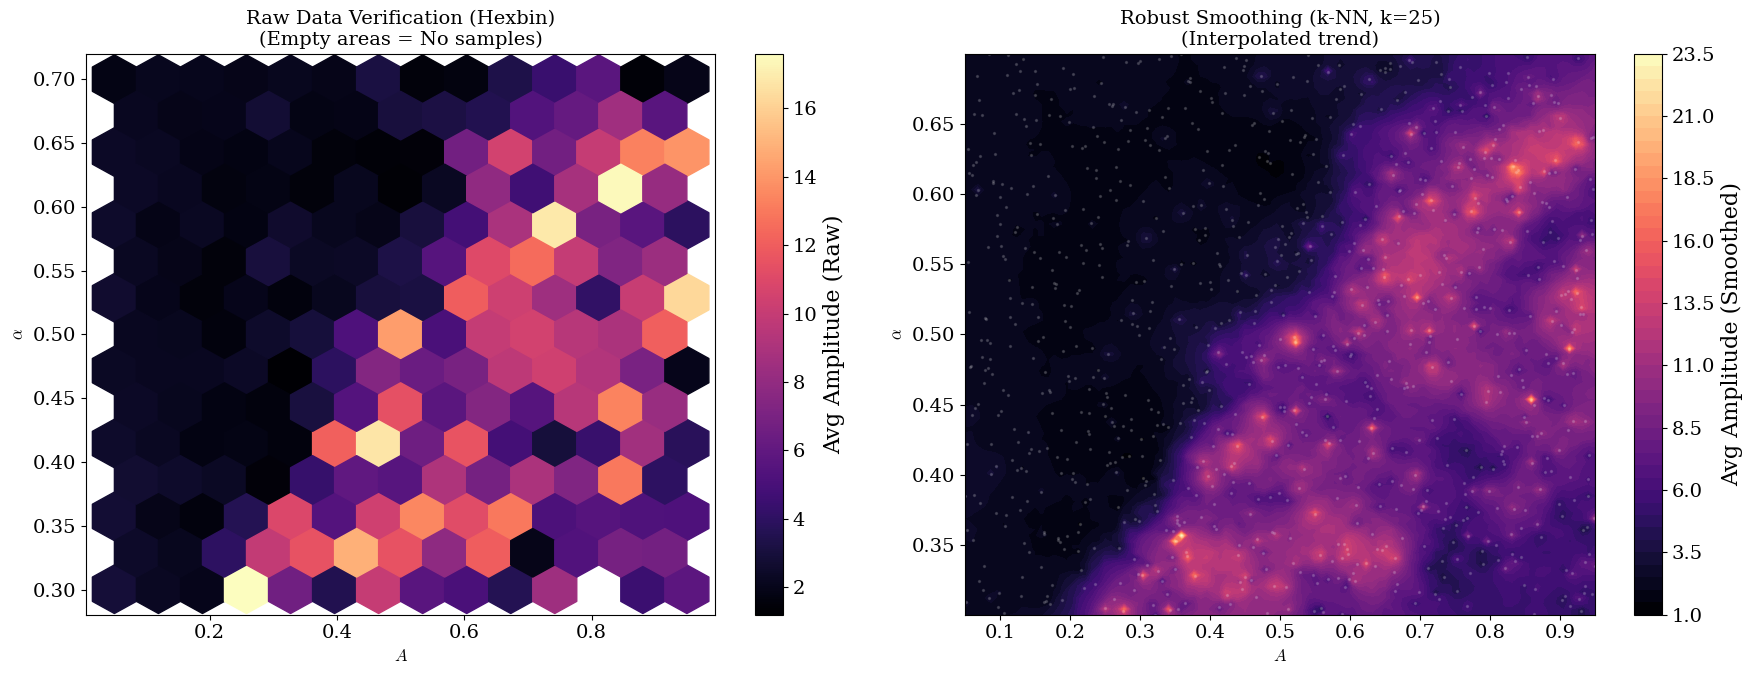

In [226]:
analyze_complete_dynamics(cpt_P, cpt_y, "CPT")

# CPT vs. PT

In [ ]:
cpt_amps = [np.mean(f["amplitudes"]) for f in cpt_data]
pt_amps  = [np.mean(f["amplitudes"]) for f in pt_data]

cpt_cycle_pt_nocycle = []
cpt_nocycle_pt_cycle = []
cpt_cycle = []
pt_cycle = []
both_cycle = []

threshold = 20

for i in range(len(cpt_amps)):
    if cpt_amps[i] >= threshold and pt_amps[i] < 10:
        cpt_cycle_pt_nocycle.append(cpt_P[i])
    elif pt_amps[i] >= threshold and cpt_amps[i] < 10:
        cpt_nocycle_pt_cycle.append(cpt_P[i])
    if pt_amps[i] >= threshold:
        pt_cycle.append(cpt_P[i])
    if cpt_amps[i] >= threshold:
        cpt_cycle.append(cpt_P[i])
    
    if pt_amps[i] >= threshold and cpt_amps[i] >= threshold:
        both_cycle.append(cpt_P[i])

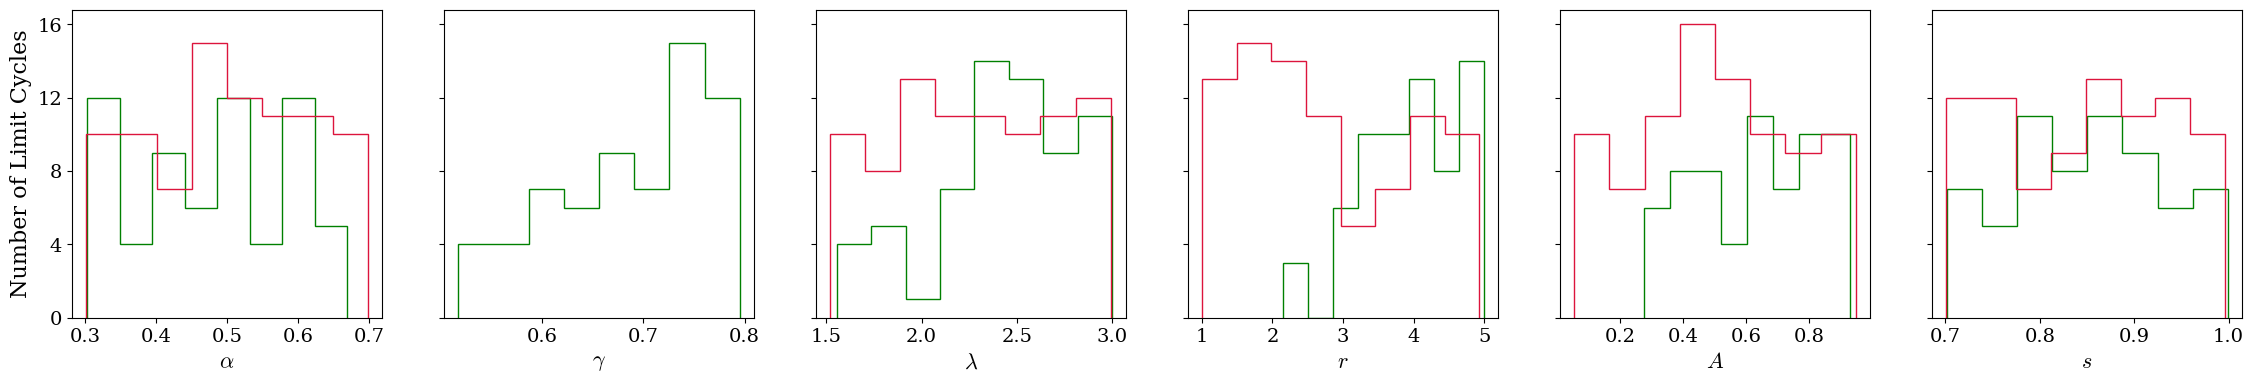

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(28,4), sharey=True)
num_bins = 8

param_names = [r"$\alpha$", r"$\gamma$", r"$\lambda$",  r"$r$", r"$A$", r"$s$"]
for idx in range(6):
    parameter = list(PARAMETER_RANGES.keys())[idx]
    axs[idx].hist(np.array(cpt_cycle)[:,idx], bins=num_bins, edgecolor="green", histtype="step")
    if idx != 1:
        axs[idx].hist(np.array(pt_cycle)[:,idx], bins=num_bins, edgecolor="crimson", histtype="step")
    axs[idx].set_xlabel(param_names[idx])

axs[0].set_ylabel("Number of Limit Cycles")
axs[0].set_yticks([0, 4, 8, 12, 16])
plt.show()

# Only PT and CPT Have Fractures in Policy Space

In [234]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_erosion, generate_binary_structure

def count_save_components(matrix):
    """
    Counts distinct 'Stable Cores' of saving behavior.
    A 'Core' is a Save state (0) where ALL 4 neighbors are also Save (0).
    This filters out thin boundary slivers.
    """
    # 1. Define 'Save' (0s)
    save_mask = (matrix == 0)
    
    # 2. Define the 'Core' condition (8-connectivity)
    neighborhood = generate_binary_structure(2, 2)
    
    # 3. Erode the mask
    # border_value=1 means we assume the outside of the chart is 'Invest'.
    # This ensures that pixels on the very edge of the image are treated as 'Boundary'
    # and eroded away, fixing your "top sliver" issue.
    core_mask = binary_erosion(save_mask, structure=neighborhood, border_value=1)
    
    # 4. Count the islands of these Cores
    # We use 8-connectivity (3x3) for labeling so diagonal cores count as one island.
    connection_structure = np.ones((3, 3))
    _, num_cores = label(core_mask, structure=connection_structure)
    
    return num_cores

In [235]:
result = {}

for i,D in enumerate(["../eut", "../pt", "../cpt"]):
    num_save_cores = []
    for f in tqdm(os.listdir(D)):
        with open(D+"/"+f, "rb") as f:
            data = pickle.load(f)
        count = count_save_components(data["policy"])
        num_save_cores.append(count)
    result[D] = num_save_cores

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

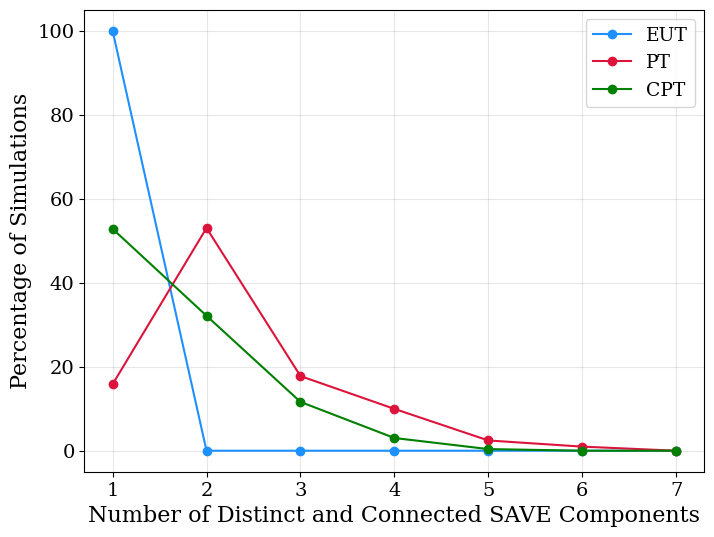

In [250]:
colors = ["dodgerblue", "crimson", "green"]
labels = ["EUT", "PT", "CPT"]

for i, key in enumerate(result):
    vals = result[key]
    plt.plot(
        [1, 2, 3, 4, 5, 6, 7],
        [100*len([v for v in vals if v == x])/1024 for x in range(1,8)],
        label=labels[i],
        color=colors[i],
        marker='o'
    )

plt.grid()
plt.xlabel("Number of Distinct and Connected SAVE Components")
plt.ylabel("Percentage of Simulations")
plt.legend()
plt.show()

In [286]:
np.where(np.array(result["../cpt"]) == 1)

(array([   0,    1,    2,    3,    7,   10,   11,   12,   23,   24,   25,
          28,   30,   31,   33,   35,   36,   37,   39,   40,   41,   42,
          43,   44,   45,   46,   47,   49,   50,   54,   55,   56,   58,
          62,   64,   67,   68,   69,   70,   72,   76,   78,   79,   80,
          82,   83,   84,   86,   87,   89,   92,   94,   98,   99,  100,
         101,  102,  104,  106,  107,  109,  110,  116,  118,  119,  120,
         121,  124,  125,  126,  127,  128,  130,  131,  132,  133,  134,
         135,  136,  138,  140,  142,  143,  144,  146,  147,  149,  150,
         152,  156,  159,  160,  163,  165,  166,  168,  169,  172,  174,
         175,  176,  177,  178,  180,  183,  186,  187,  188,  190,  191,
         193,  194,  195,  196,  198,  199,  201,  202,  204,  207,  213,
         214,  215,  216,  220,  221,  224,  225,  226,  229,  230,  236,
         237,  240,  244,  245,  248,  250,  256,  260,  261,  262,  265,
         266,  268,  272,  274,  275, 

  0%|          | 0/1024 [00:00<?, ?it/s]

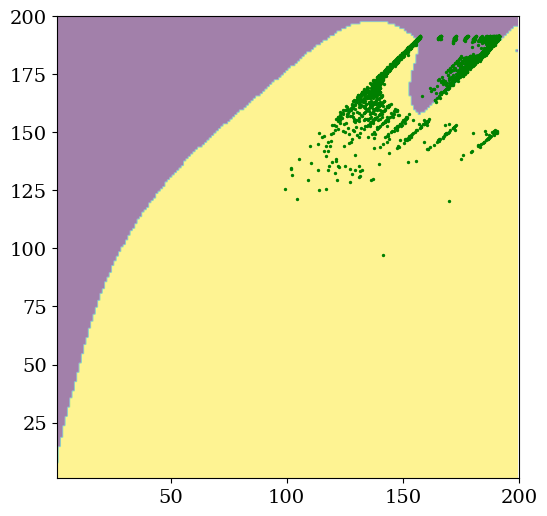

In [293]:
directory = "cpt"

for idx, f_name in enumerate(tqdm(os.listdir("../"+directory))):
    if idx == 1:
        with open(os.path.join("../"+directory, f_name), "rb") as f:
            res = pickle.load(f)
        P = res["params"]
        w = unpack_and_dequantize(res["wealth"][:,-1], 200)
        h = unpack_and_dequantize(res["health"][:,-1], 200)
        plt.imshow(res["policy"].T, origin="lower", alpha=0.5)
        plt.scatter(
            w, 
            h,
            s=2,
            color="green"
        )
        plt.xlim(1,200)
        plt.ylim(1,200)
        plt.show()

# Visualize Limit Cycles

  0%|          | 0/1024 [00:00<?, ?it/s]

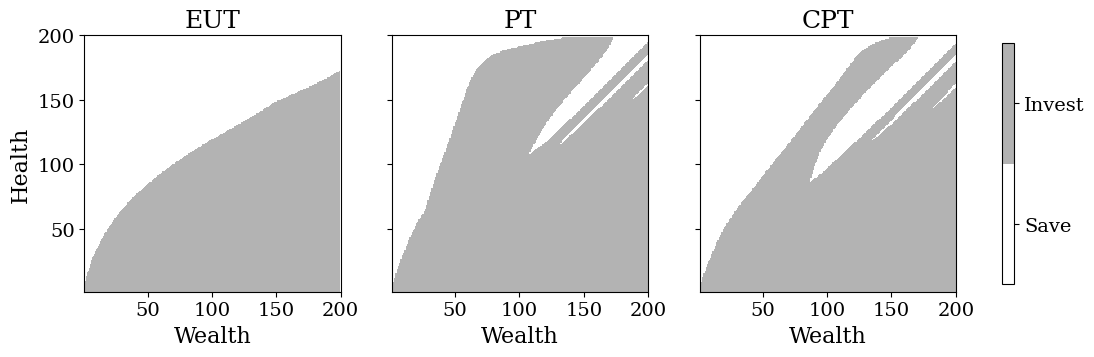

In [ ]:
directory = "cpt"

with open("../"+directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
    freqs = pickle.load(f)
sims = [int(np.mean(f["amplitudes"]) >= 25) for f in freqs]

def plot_trajectories(ax, res, color, indices):
    """
    Helper function to plot random agent trajectories with arrows.
    """
    for i in indices:
        w_path = unpack_and_dequantize(res["wealth"][i, :500], 200)
        h_path = unpack_and_dequantize(res["health"][i, :500], 200)
        ax.plot(w_path, h_path, color=color, alpha=0.5, linewidth=1)
        x = w_path[:-1]
        y = h_path[:-1]
        u = np.diff(w_path)
        v = np.diff(h_path)
        ax.quiver(x, y, u, v, color=color, alpha=0.5, 
                  angles='xy', scale_units='xy', scale=1, 
                  width=0.006, headwidth=4, headlength=5)

for idx, f_name in enumerate(tqdm(os.listdir("../"+directory))):
    if sims[idx]:
        fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

        # Define a discrete binary colormap for consistency across plots
        # This divides the 'Greys' map into exactly 2 colors
        binary_cmap = plt.cm.get_cmap('Greys', 2)

        # --- CPT ---
        with open(os.path.join("../"+directory, f_name), "rb") as f:
            res = pickle.load(f)
        P = res["params"]

        w_start = res["wealth"][:, 0]
        h_start = res["health"][:, 0]

        # Determine midpoint based on data range (handles normalized 0-1 or integer 0-200)
        # We assume the plot limits (200) represent the full scale.
        data_max = np.max(w_start)
        mid = 100 if data_max > 1 else 0.5

        # Define masks for the 4 quadrants (Cartesian plane logic)
        # Q1: Top-Right (High Wealth, High Health)
        # Q2: Top-Left (Low Wealth, High Health)
        # Q3: Bottom-Left (Low Wealth, Low Health)
        # Q4: Bottom-Right (High Wealth, Low Health)
        quadrants = [
            (w_start >= mid) & (h_start >= mid), # Q1
            (w_start < mid) & (h_start >= mid),  # Q2
            (w_start < mid) & (h_start < mid),   # Q3
            (w_start >= mid) & (h_start < mid)   # Q4
        ]
        indices = []
        for mask in quadrants:
            candidates = np.where(mask)[0]
            if len(candidates) >= 1:
                picked = np.random.choice(candidates, 1, replace=False)
            else:
                picked = candidates
            indices.extend(picked)
        indices = np.array(indices)
        
        w = unpack_and_dequantize(res["wealth"][:,-1], 200)
        h = unpack_and_dequantize(res["health"][:,-1], 200)
        axs[2].imshow(res["policy"].T, origin="lower", cmap=binary_cmap, alpha=0.3)
        # axs[2].scatter(
        #     w, 
        #     h,
        #     s=2,
        #     color="green"
        # )
        axs[2].set_xlim(1, 200)
        axs[2].set_ylim(1, 200)
        axs[2].set_title("CPT")
        axs[2].set_xlabel("Wealth")
        #plot_trajectories(axs[2], res, "green", indices)


        # --- PT ---
        pt_f = f"{P['alpha']}_1.0_{P["lambda"]}_{P['rate']}_{P['A']}_{P['shock_size']}.pickle"
        with open(os.path.join("../pt", pt_f), "rb") as f:
            res = pickle.load(f)
        
            
        axs[1].imshow(res["policy"].T, origin="lower", cmap=binary_cmap, alpha=0.3)
        w = unpack_and_dequantize(res["wealth"][:,-1], 200)
        h = unpack_and_dequantize(res["health"][:,-1], 200)
        # axs[1].scatter(
        #     w, 
        #     h,
        #     s=2,
        #     color="crimson"
        # )
        axs[1].set_xlim(1, 200)
        axs[1].set_ylim(1, 200)
        axs[1].set_title("PT")
        axs[1].set_xlabel("Wealth")
        #plot_trajectories(axs[1], res, "crimson", indices)


        # --- EUT ---
        eut_f = f"{P['alpha']}_1.0_1.0_{P['rate']}_{P['A']}_{P['shock_size']}.pickle"
        with open(os.path.join("../eut", eut_f), "rb") as f:
            res = pickle.load(f)
            
        # Capture the image object (im) to pass to colorbar
        im = axs[0].imshow(res["policy"].T, origin="lower", cmap=binary_cmap, alpha=0.3, vmin=0, vmax=1)
        w = unpack_and_dequantize(res["wealth"][:,-1], 200)
        h = unpack_and_dequantize(res["health"][:,-1], 200)
        # axs[0].scatter(
        #     w, 
        #     h,
        #     s=2,
        #     color="dodgerblue"
        # )
        axs[0].set_xlim(1, 200)
        axs[0].set_ylim(1, 200)
        axs[0].set_title("EUT")
        axs[0].set_xlabel("Wealth")
        axs[0].set_ylabel("Health")
        #plot_trajectories(axs[0], res, "dodgerblue", indices)

        cbar = fig.colorbar(im, ax=axs, location='right', ticks=[0.25, 0.75], fraction=0.013)
        cbar.ax.set_yticklabels(['Save', 'Invest'])
        plt.savefig("../figures/policy_trajectories_cycle.pdf", bbox_inches="tight")
        plt.show()
        break